- 미니 배치 학습
: 데이터가 많은 경우 일부를 추려 근사치로 이용하여 학습을 수행한다. 

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

In [2]:
(x_train, t_train), (x_test, t_test) =\
load_mnist(normalize=True, one_hot_label=True)

print("x_train shape:::",x_train.shape)
print("t_train shape:::",t_train.shape)

x_train shape::: (60000, 784)
t_train shape::: (60000, 10)


**!!!**  \ -> 무엇인가.. 자동생성해주네

one_hot_label : 정답 위치의 원소만 1 나머지는 0

    - dataset에서 무작위로 10장만 뺀다

In [3]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

print("x_batch:::", x_batch)
print("t_batch:::", t_batch)
print("batch_mask:::", batch_mask)

x_batch::: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
t_batch::: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
batch_mask::: [54651 29499 29276 15797  5243 56510 10163   684 39527 54083]


뭐여...뭐야??
아 batch_mask가 데이터의 인덱스가 됨. 인덱스마다 배열이 들어있음
np.random.choice : 지정한 범위의 수중에서 무작위로 원하는 개수만 꺼낼 수 있다.

- 배치용 교차 엔트로피 오차 구현
미니 배치 같은 데이터를 처리할 수 있는 교차 엔트로피 구현

In [4]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)        
    batch_size = y.shape[0]
    
    return -np.sum(t * np.log(y)) / batch_size

y는 신경망의 출력, t는 정답 레이블
y가 1차원이라면, *즉 데이터 하나당 교차 엔트로피 오차를 구하는 경우* reshape 함수로 데이터의 형상을 바꿔준다. 그리고 배차(?)의 크기로 나눠 정규화하고 *이미지 1장당 편귱 교차 엔트로피 오차를 계산*

- 정답 레이블이 원핫코딩이 아니라 숫자 레이블로 주어졌을 경우 구현

In [5]:
def cross_entropy_error2(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    
    return -np.sum(np.lag(y[np.arrange(batch_size), t])) / batch_size

위 구현의 핵심 : 원-핫 인코딩일 때 t가 0인 원소는 교차 엔트로피 오차도 0이므로 그 계산은 무시해도 좋다는 것. 즉 정답에 해당하는 신경망의 출력만으로 교차 엔트로피 오차를 계산할 수 있다. 그래서 np.log(y) 부분을 np.lag(y[np.arrange(batch_size), t]로 구현

np.arrange(batch_size)는 0부터 batch_size-1 까지 배열을 생성한다. 즉 batch_size가 5이면 [0, 1, 2, 3, 4] 배열을 생성한다. t에는 레이블이 [2, 7, 0, 9, 4]와 같이 저장되 있으므로 y[np.arrange(batch_size), t]는 각 데이터의 정답 레이블에 해당하는 신경망의 출력을 추출한다. 

위 예시로 보면 [y[0, 2], y[1, 7], y[2, 0], y[3, 9], y[4, 4]]를 반환한다.

#### 4.3 수치미분

경사법에서는 기울기 값을 기준으로 나아갈 방향을 정한다. 

1. 미분
어떤 작은 변화가 함수를 얼마나 변화시키는가

**나쁜 구현 예**

In [6]:
def numerical_diff(f, x):
    h = 10e-50
    return (f(x + h) - f(x)) / h

h에 가능한한 무한히 0에 가깝게 하기 위해서 10e-50을 사용했다. 그러나 이 방식은 **반올림 오차** 문제를 일으킨다.
반올림 오차는 작은값이 생략되어 최종 계산 결과에 오차가 생기게 한다. 즉 0.0이 되버려서 올바른 표현이 어렵다

또, 진정한 미분은 x 위치의 함수의 기울기에 해당하지만 위 구현에서의 미분은 (x+h)와 x 사이의 기울기에 해당한다. 그래서 진정한 미분과 일치 하지 않음. 이 차이는 h를 무한히 0으로 좁히는 것이 불가능해서 생기는 문제로 수치 미분에는 오차가 포함됨.
이 오차를 줄이기 위해 (x + h)와 (x - h)일 때의 함수f의 차분을 계산하는 방법을 쓰기도 한다.



##### 4.3.1 미분 #####


In [7]:
def numerical_diff(f, x):    # 미분 함수, 미분 수식
    h = 1e-4    # 0.0001 - : 연산 아님 띄어쓰기 하면 안됨
    return (f(x+h) - f(x-h)) / (2*h)

##### 4.3.2 수치 미분


In [8]:
def function_1(x):    # 미분할 함수
    return 0.01 * x ** 2 + 0.1 * x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d * x
    
    return lambda t: d * t + y

0.2999999999986347


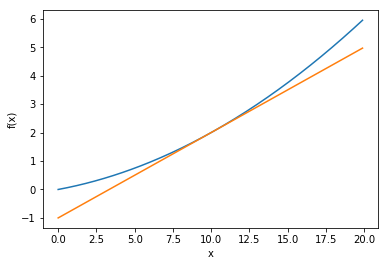

In [9]:
%matplotlib inline
# 워였더라 이거
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)    #0.0부터 20.0까지 0.1 간격으로 배열을 반환
y = function_1(x)    # f(x)

tf = tangent_line(function_1, 10)    #x=10 왜???
y2 = tf(x)    # 위 결과tf가 함수?

plt.xlabel('x'); plt.ylabel('f(x)')
plt.plot(x, y)
plt.plot(x, y2)
plt.show()
# feth 하지 못함

##### 4.3.3 편미분

#### 4.4 기울기
x0, x1 양쪽의 편비문을 묶어서 계산. 이와 같이 모든 변수의 편미분을 벡터로 나타낸 것을 기울기라고 한다.


In [10]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4
    grad = np.zeros_like(x)    # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]    # 인자의 배열에 각 데이터
        
        #f(x+h) 
        x[idx] = float(tmp_val) + h   # 배열에 x + h 값을 삽입?
        fxh1 = f(x)    # 여기서 x는 위 값인가?
        
        #f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)    # x와 형상이 같은 새로 생성한 배열에 넣음
        x[idx] = tmp_val    # 값 복원
        
        return grad
    

def numerical_gradient(f, X):
    if X.ndim == 1:    #  ndim -> 배열이 몇 차원 배열인지
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

In [11]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)     #axis???
    

def tangent_line(f,x):
    d = numerical_gradient(f, x)
    prinf(d)
    y = f(x) - d*x
    
    return lambda t: d*t + y
    

No handles with labels found to put in legend.


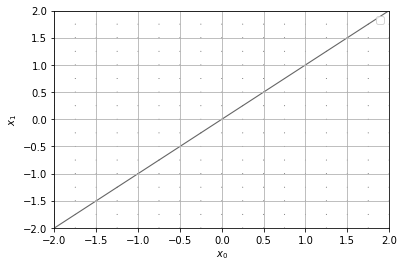

In [12]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)     # meshgrid??

X = X.flatten()      # flatten??
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.grid()
plt.legend()
plt.draw()
plt.show()

 왜 달라..? 어디 오타야~!~
 
 
 ##### 4.4.1 경사법
 
 최적*(손실 함수가 최소값이 될 때의 매개변수 값)*의 매개변수를 학습 단계에서 찾아야 한다.
 그러나 매개변수 공간이 광대해 어디가 최소값이 되는 곳인지 알아내기 쉽지 않아서 기울기를 이용해서 함수의 최소값을 찾으려는 것이 **경사법**
 
 
 각 지점에서 함수의 값을 낮추는 방안을 제시하는 지표가 기울기다. 하지만 그 기울기가 가리키는 곳이 정말 함수의 최소값이 있는지는 보장할 수 없다. **실제로 최소값이 없는 경우가 대부분**
 그러나 그 방향으로 가야 함수의 값을 줄일 수 있다. 
 
 **경사법** : 현재 위치에서 기울어진 방향으로 일정 거리를 이동하고, 이동한 위치에서 기울기를 구하고 그 방향으로 나아가는 것을 반복한다. 이렇게 점차 함수의 값을 줄이는 것. *기계학습 최적화로 주로 쓰인다.*
 
 경사법 수식 (1회 - 이 수식을 반복한다)
 
 ![경사법 수식](./image/img1.JPG)
 
 갱신하는 양을 나타냄. 신경망 학습에서는 학습량. -> 한 번의 학습을 얼마만큼 해야하는지 = 매개변수 값을 얼마나 갱신하는가를 정하는 것
 
 **학습률 값은 미리 정해두어야 한다.** 이 값이 너무 크거나 작으면 좋지 않음.
 신경망 학습에서는 보통 이 학습률 값을 변경하면서 올바르게 학습하고 있는지를 확인하면서 진행
 *학습률처럼 사람이 직접 설정해야하는 매개변수를 **하이퍼파라미터**라고한다*
 
 * 경사 하강법 함수 구현

In [13]:
"""
f : 최적화 하려는 함수
init_x : 초기값
lr : learning rate, 학습률
step_num : 경사법 반복 횟수

"""

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):    # step_num만큼 반복
        grad = numerical_gradient(f, x)    # 함수의 기울기를 구함
        x -= lr * grad    # 계산된 기울기에 학습률을 곱한다.
    
    return x

* 경사법으로 ![](.\image\img2.JPG)를 구현

In [14]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    # 초기값(-3.0, 4.0)
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)


array([-6.10953066e-10,  4.00000000e+00])

결과는 거의 (0, 0)에 가까운 결과. 


* 경사법 갱신 과정을 그림으로 구현
   값이 가장 낮은 장소인 원점에 점차 가까워지고 있다.
   

In [15]:
def gradient_descent2(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

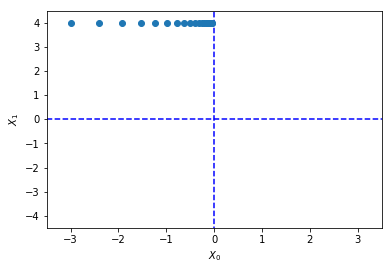

In [16]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent2(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")
plt.show()

.. .....~~


* 학습률이 너무 큰 경우


In [17]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)


array([-2.58984259e+13,  4.00000000e+00])

* 학습률이 너무 작은 경우

In [18]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  4.        ])

##### 4.2.2 신경망에서의 기울기


신경망 학습에서 기울기는 가중치 매개변수에 관한 손실함수의 기울기이다.

예를들어 아래 신경망일 경우
    형상 : 2X3
    가중치 : W
    손실함수 : L
        경사는 ![](.\image\img3.JPG) 
        수식은 ![](.\image\img4.JPG)
    ![](.\image\img3.JPG) 의 각 원소는 각각의 원소에 대한 편미분이다. 예를 들면 1행 1번째 원소는 
    가중치의 1행 1번째 가중치를 조금 변경했을 때 손실 함수 L이 얼마나 변화하느냐를 나타낸다.
    
    
   
   * 간단한 신경망을 예로 기울기 구현
        

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_enrtopy_error
from common.gradient import numerical_gradient